In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage
import seaborn as sns

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [5]:
%matplotlib widget

In [6]:
plotdir = r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\spont_FR"

### Functions

In [7]:
## Using bombcell classification for striatum (https://github.com/Julie-Fabre/bombcell/blob/main/py_bombcell/bombcell/classification.py)
def get_put_cell_types(unit_info):
    put_cell_type = []
    for unitind, unitrow in unit_info.iterrows():
        if unitrow.parent_region == 'STR':
            if unitrow.spike_duration < 0.475:
                put_cell_type.append('FS')
            elif unitrow.spike_duration > 0.55:
                if unitrow.CV_ISI_out < 1.0: # Masmanidis lab uses 1.5, Berke lab opto tagging of TANs finds most CV<1.0; also tried CV only out of SWD; also tried CV2<1.0
                    put_cell_type.append('TAN')
                else:
                    put_cell_type.append('MSN')
            else:
                put_cell_type.append('unknown')
        elif unitrow.parent_region in ['MO', 'SS', 'VIS', 'PL', 'ACA', 'ILA', 'ORB', 'RSP', 'HIP']:
            if unitrow.spike_duration < 0.4:
                put_cell_type.append('FS')
            else:
                put_cell_type.append('RS')
        elif unitrow.parent_region == 'TH':
            if unitrow.spike_duration < 0.33:
                put_cell_type.append('pRT')
            else:
                put_cell_type.append('TC')
        else:
            put_cell_type.append('unknown')
    unit_info['cell_type'] = put_cell_type
    return unit_info

# Load multi session .csv

In [8]:
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\GAT1_control_NPephys_subjects.csv")
all_subexp = pd.read_csv(subject_csv, converters={'mouse': str})
all_subexp.head()

,genotype,mouse,experiment,drug,inj_time,sweep_states,bad_chs,CCFres,NPX_analysis,EEG_analysis,skull_screws,NPX_ref,EEG_ref,shared_ref_gnd,data_loc,notes
0,GAT1-KO,645606,EEGNPXspont_estim_2022-12-20_12-26-39,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_esti...,100um offset stim electrode
1,GAT1-KO,644565,EEGNPXspont_estim_2022-12-22_10-36-08,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_esti...,"100um offset stim electrode, probeB LFP estim ..."
2,GAT1-KO,672785,EEGNPXspont_estim_2023-07-05_12-39-59,none,0,awake,all,25,True,False,2.0,Neuropixels tip reference electrode,"stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672785\EEGNPXspont_esti...,EEG has low amplitude signals and all chs look...
3,GAT1-KO,672789,EEGNPXspont_estim_2023-07-13_13-28-01,none,0,awake,none,25,True,True,2.0,"stainless steel skull screw, right CB","stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_esti...,NaN
4,wildtype,654181,estim_vis_2022-11-22_09-42-58,isoflurane,0,"awake,isoflurane","7,8,11,13",25,True,True,NaN,NaN,NaN,NaN,F:\psi_exp\mouse654181\estim_vis_2022-11-22_09...,good control mouse with RT units


# Loop through all subjects to plot spontaneous firing rate for all units

In [10]:
deltat = 1. # window size, s

all_unit_info_list = []
for expind, exprow in all_subexp.iterrows():
    print('{} - {}'.format(exprow.mouse, exprow.experiment))
    if not exprow.NPX_analysis:
        print(' This experiment does NOT have good NPX data, skip it.\n\n')
        continue
    ## Load the experiment ##
    exp = EEGexp(exprow.data_loc, preprocess=False, make_stim_csv=False)
    exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]

    ########## Load necessary data ##########
    ## Load the stim log ##
    if exp.stimulus_log_file:
        stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    else:
        print(' No stim log found.\n\n')
        continue
    ## Get the EEG clock timestamps ##
    eegts = np.load(exp.ephys_params['EEG']['timestamps']).0000000
    ## Load the iso times ##
    iso_level, isots = exp.load_analog_iso()

    ## Load unit info ##
    evoked_folder = os.path.join(exp.data_folder, 'evoked_data')
    fn_units_info = os.path.join(evoked_folder, 'all_units_info.csv')
    if os.path.exists(fn_units_info):
        unit_info = pd.read_csv(fn_units_info)
        with open(os.path.join(evoked_folder, 'units_allspikes.pkl'), 'rb') as unit_file:
            all_unit_all_spikes = pickle.load(unit_file)
    else:
        print('{} not found. Not analyzing this subject.\n\n'.format(fn_units_stats))
        continue
    #########################################

    ########## Get spontaneous times ##########
    if exprow.genotype == 'GAT1-KO':
        print(' GAT1: choose time before any stimuli')
        btime = stim_log.onset.values[0]
        print('  Spontaneous time: {:.2f} s'.format(btime-eegts[0]))
    else:
        print(' Control: some experiments are saline/psilocybin/isoflurane')
        if exprow.drug == 'isoflurane':
            print('  First stim: {:.2f} s; Iso on: {:.2f} s'.format(stim_log.onset.values[0], isots[iso_level > 4][0]))
            btime = np.min([stim_log.onset.values[0], isots[iso_level > 4][0]])
            print('  Spontaneous time: {:.2f} s'.format(btime-eegts[0]))
        else:
            print('  First stim: {:.2f} s; First injection: {:.2f}'.format(stim_log.onset.values[0], exprow.inj_time))
            btime = np.min([stim_log.onset.values[0], exprow.inj_time])
            print('  Spontaneous time: {:.2f} s'.format(btime-eegts[0]))
    spontbins = np.arange(eegts[0], btime, deltat)
    if exprow.genotype == 'GAT1-KO':
        auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
        autoSWD_df = pd.read_pickle(auto_annot_file)
        spontSWD = autoSWD_df[(autoSWD_df['onset'] > eegts[0]) & (autoSWD_df['offset'] < btime)]
    ###########################################
    
    ## Print some info about regions ##
    print(' REGIONS:')
    for pregi in np.unique(unit_info['parent_region'].values):
        pudf = unit_info[unit_info['parent_region'] == pregi]
        print('  {}: {:d} units'.format(pregi, len(pudf)))
        # print(np.unique([x for x in pudf.region.values if isinstance(x, str)]))

    ## Get the mean firing rate for all states and add it to the unit_info df ##
    spontFR = []
    spontBR = []
    spont_burstratio = []
    ISI_CV = []
    ISI_CV_out = []
    prop2 = []
    for unitind, unitrow in unit_info.iterrows():
        uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
        ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
        ubcs = all_unit_all_spikes[unitrow.unit_id]['burst_counts']
        ## Spontaneous ##
        spikecounts, edges = np.histogram(uspikes, spontbins)
        spontFR.append(np.mean(spikecounts / deltat))
        burstcounts, edges = np.histogram(ubursts, spontbins)
        spontBR.append(np.mean(burstcounts / deltat))
        ## Burst ratio ##
        spont_burstratio.append(
            np.sum(ubcs[np.nonzero((ubursts >= eegts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eegts[0]) & (uspikes <= btime))[0]))
        ## ISI CV ##
        uISI = np.diff(uspikes)
        ISI_CV.append(np.std(uISI) / np.mean(uISI))
        prop2.append(np.sum(uISI > 2) / len(uISI))
        if exprow.genotype == 'GAT1-KO':
            # in_ISI = []
            out_ISI = []
            for j in range(len(spontSWD)-1):
                SWDeventj = spontSWD.iloc[j]
                SWDeventjj = spontSWD.iloc[j+1]
                ## within SWD ##
                # SWDspikes = uspikes[np.nonzero((uspikes >= SWDeventj.onset) & (uspikes <= SWDeventj.offset))[0]]
                # if len(SWDspikes) > 1:
                #     in_ISI.append(np.diff(SWDspikes))
                ## out of SWD ##
                nonSWDspikes = uspikes[np.nonzero((uspikes >= SWDeventj.offset) & (uspikes <= SWDeventjj.onset))[0]]
                if len(nonSWDspikes) > 1:
                    out_ISI.append(np.diff(nonSWDspikes))
            if len(out_ISI) > 1:
                ISI_CV_out.append(np.std(np.concatenate(out_ISI)) / np.mean(np.concatenate(out_ISI)))
            else:
                ISI_CV_out.append(np.nan)
                
    unit_info['spont_FR'] = spontFR
    unit_info['spont_BR'] = spontBR
    unit_info['burst_ratio'] = spont_burstratio
    unit_info['CV_ISI'] = ISI_CV
    unit_info['prop2'] = prop2
    unit_info['mouse'] = [exprow.mouse] * len(unit_info)
    unit_info['exp'] = [exp_tag] * len(unit_info)
    unit_info['genotype'] = [exprow.genotype] * len(unit_info)
    if exprow.genotype == 'GAT1-KO':
        unit_info['CV_ISI_out'] = ISI_CV_out
    else:
        unit_info['CV_ISI_out'] = ISI_CV

    #### Apply cell type classification ####
    unit_info = get_put_cell_types(unit_info)
    
    ## Save the unit df for all sessions ##
    all_unit_info_list.append(unit_info)
    print('\n\n')

all_units_info = pd.concat(all_unit_info_list, ignore_index=True)

645606 - EEGNPXspont_estim_2022-12-20_12-26-39
Experiment type: electrical stimulation
 GAT1: choose time before any stimuli
  Spontaneous time: 2951.75 s
 REGIONS:
  HIP: 101 units
  MO: 273 units
  PAL: 45 units
  PTLp: 24 units
  SS: 405 units
  STR: 583 units
  TH: 152 units



644565 - EEGNPXspont_estim_2022-12-22_10-36-08
Experiment type: electrical stimulation
 GAT1: choose time before any stimuli
  Spontaneous time: 2932.62 s
 REGIONS:
  HIP: 160 units
  MO: 291 units
  PAL: 17 units
  PTLp: 28 units
  SS: 207 units
  STR: 554 units
  TH: 316 units



672785 - EEGNPXspont_estim_2023-07-05_12-39-59
Experiment type: electrical and sensory stimulation
 GAT1: choose time before any stimuli
  Spontaneous time: 1886.30 s
 REGIONS:
  HIP: 325 units
  MO: 282 units
  PAL: 45 units
  PTLp: 25 units
  RHP: 99 units
  RSP: 104 units
  SS: 116 units
  STR: 586 units
  TH: 740 units
  VIS: 181 units


C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in double_scalars





672789 - EEGNPXspont_estim_2023-07-13_13-28-01
Experiment type: electrical and sensory stimulation
 GAT1: choose time before any stimuli
  Spontaneous time: 1723.91 s
 REGIONS:
  HIP: 362 units
  MO: 157 units
  PAL: 144 units
  SS: 302 units
  STR: 622 units
  TH: 582 units
  VIS: 59 units


C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in double_scalars





654181 - estim_vis_2022-11-22_09-42-58
Experiment type: electrical and sensory stimulation
 Control: some experiments are saline/psilocybin/isoflurane
  First stim: 713.20 s; Iso on: 2962.78 s
  Spontaneous time: 600.88 s
 REGIONS:
  HIP: 132 units
  MO: 285 units
  PAL: 35 units
  SS: 408 units
  STR: 178 units
  TH: 366 units



669118 - pilot_aw_2023-03-23_12-14-39
 This experiment does NOT have good NPX data, skip it.


669117 - pilot_aw_2023-03-29_11-09-15
 This experiment does NOT have good NPX data, skip it.


569064 - estim_vis_2021-04-08_10-28-24
 This experiment does NOT have good NPX data, skip it.


569068 - estim_vis_2021-03-04_10-51-38
 This experiment does NOT have good NPX data, skip it.


666196 - pilot_aw_2023-03-15_12-29-06
Experiment type: electrical and sensory stimulation
 Control: some experiments are saline/psilocybin/isoflurane
  First stim: 138.15 s; First injection: 730.00
  Spontaneous time: 123.08 s
 REGIONS:
  FRP: 49 units
  HIP: 326 units
  MO: 133 un

In [11]:
all_units_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,spont_FR,spont_BR,burst_ratio,CV_ISI,prop2,mouse,exp,genotype,CV_ISI_out,cell_type
0,B0,probeB,0,3640,0.467002,VAL,258,151,176,12.807218,0.99,0.009902,0.000319,56158,TH,14.950864,0.189088,0.024674,2.481165,0.000534,645606,EEGNPXspont_estim,GAT1-KO,1.244231,TC
1,B1,probeB,0,3640,0.453266,VAL,258,151,176,0.971066,0.99,2.447504,0.192962,4258,TH,1.204338,0.025415,0.038245,1.854004,0.134602,645606,EEGNPXspont_estim,GAT1-KO,1.155467,TC
2,B2,probeB,0,3640,0.439531,VAL,258,151,176,2.587761,0.99,0.395704,0.500000,11347,TH,2.271772,0.071162,0.054993,1.431050,0.013044,645606,EEGNPXspont_estim,GAT1-KO,1.145371,TC
3,B3,probeB,2,3620,0.508208,VAL,258,150,176,2.201205,0.99,0.758586,0.500000,9652,TH,1.723145,0.036259,0.036753,1.490809,0.025075,645606,EEGNPXspont_estim,GAT1-KO,1.087877,TC
4,B4,probeB,1,3640,0.425796,VAL,258,150,176,2.222870,0.99,0.743871,0.500000,9747,TH,2.158251,0.054219,0.045504,1.501723,0.020829,645606,EEGNPXspont_estim,GAT1-KO,1.014501,TC


In [32]:
gtmap = {'GAT1-KO': 'SLC6A1-/-', 'wildtype': 'C57-WT'}
new_geno = [gtmap[x] for x in all_units_info['genotype']]
all_units_info['genotype'] = new_geno

all_units_info['log10spFR'] = np.log10(all_units_info['spont_FR'].values + 1E-3)
all_units_info['log10spBR'] = np.log10(all_units_info['spont_BR'].values + 1E-3)

In [33]:
print(len(all_units_info))

27846


### Plot all units

In [35]:
## Subselect units to remove low spiking ones ##
# all_select_units = all_units_info[all_units_info['spike_count'] > 500]
all_select_units = all_units_info[all_units_info['spont_FR'] > 0.05]

print(len(all_select_units))

24951


In [36]:
print(np.unique(all_select_units['parent_region'].values))

['ACA' 'FRP' 'HIP' 'MB' 'MO' 'OLF' 'ORB' 'PAL' 'PL' 'PTLp' 'RHP' 'RSP'
 'SS' 'STR' 'TH' 'VIS']


In [37]:
print(np.unique(all_select_units[all_select_units['parent_region'] == 'TH']['region'].values))

['AD' 'AMd' 'AMv' 'AV' 'CL' 'Eth' 'FF' 'HY' 'IAD' 'LD' 'LGd-co' 'LGd-sh'
 'LGv' 'LP' 'MD' 'MGd' 'MGm' 'MGv' 'PCN' 'PIL' 'PO' 'POL' 'PoT' 'RT' 'SGN'
 'TH' 'VAL' 'VL' 'VPL' 'VPM' 'ZI' 'alv' 'em' 'fi' 'fiber tracts' 'int'
 'ml' 'or' 'root' 'st']


#### Firing rate

In [38]:
pregions = ['MO', 'SS', 'VIS', 'TH', 'HIP', 'STR']
pselect = []
for pregi in pregions:
    pselect.append(all_select_units[all_select_units['parent_region'] == pregi])
parentdf = pd.concat(pselect, ignore_index=True)
print(np.unique(parentdf['parent_region'].values))

['HIP' 'MO' 'SS' 'STR' 'TH' 'VIS']


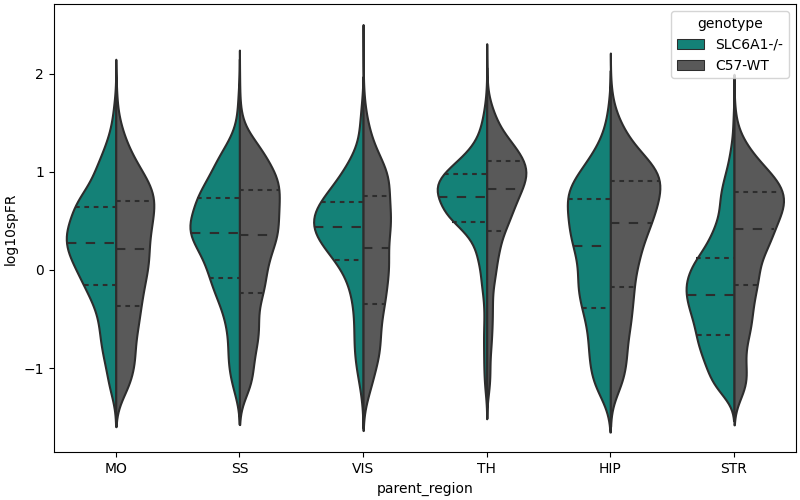

In [47]:
## Spont FR ##
fig = plt.figure(figsize=(8,5), constrained_layout=True)
sns.violinplot(
    data=parentdf, x='parent_region', y='log10spFR', hue='genotype',
    split=True, inner="quart", palette={"SLC6A1-/-": "xkcd:teal", "C57-WT": ".35"}
)
## Save ##
figname = 'multisub_SLC-WT_spontFR_allmajorregions_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

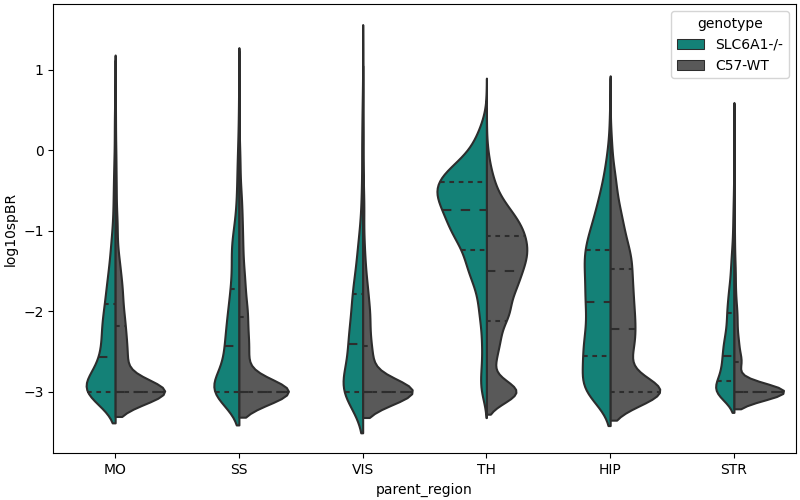

In [48]:
## Spont BR ##
fig = plt.figure(figsize=(8,5), constrained_layout=True)
sns.violinplot(
    data=parentdf, x='parent_region', y='log10spBR', hue='genotype',
    split=True, inner="quart", palette={"SLC6A1-/-": "xkcd:teal", "C57-WT": ".35"}
)
## Save ##
figname = 'multisub_SLC-WT_spontBR_allmajorregions_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

#### For cortical regions, split into RS/FS

In [49]:
pregions = ['MO', 'SS', 'VIS']
pselect = []
for pregi in pregions:
    pselect.append(all_select_units[all_select_units['parent_region'] == pregi])
parentdf = pd.concat(pselect, ignore_index=True)
print(np.unique(parentdf['parent_region'].values))

['MO' 'SS' 'VIS']


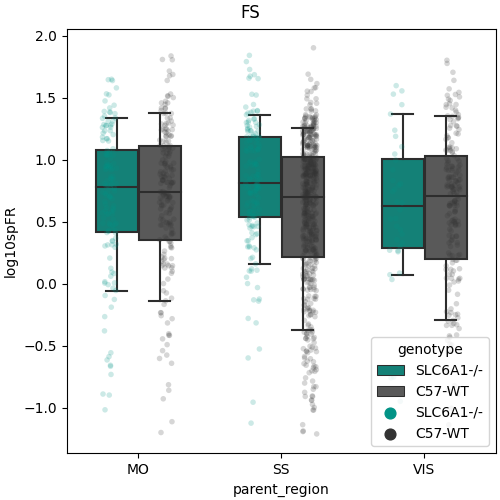

In [70]:
plot_ct = 'FS'
plotdf = parentdf[parentdf['cell_type'] == plot_ct]

fig = plt.figure(figsize=(5,5), constrained_layout=True)
sns.boxplot(
    data=plotdf, x="parent_region", y="log10spFR", hue="genotype",
    whis=[10, 90], showfliers=False, width=.6, palette={"SLC6A1-/-": "xkcd:teal", "C57-WT": ".35"}
)
sns.stripplot(
    data=plotdf, x="parent_region", y="log10spFR", hue="genotype", size=4, palette={"SLC6A1-/-": "xkcd:teal", "C57-WT": ".2"}, dodge=True, alpha=0.2
)
fig.suptitle(plot_ct)
## Save ##
figname = 'multisub_SLC-WT_spontFR_cortex{}_{}.png'.format(plot_ct, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

#### For striatum

In [73]:
pregions = ['STR']
pselect = []
for pregi in pregions:
    pselect.append(all_select_units[all_select_units['parent_region'] == pregi])
parentdf = pd.concat(pselect, ignore_index=True)
print(np.unique(parentdf['parent_region'].values))
print(np.unique(parentdf['region'].values))
print(len(parentdf))

['STR']
['CP' 'LSr' 'LSv' 'SH' 'STR' 'VL' 'ccb' 'ccg' 'fa' 'fiber tracts' 'or'
 'st']
4163


In [82]:
region = 'LSr'
regidf = all_select_units[all_select_units['region'] == region]
print(np.unique(regidf['cell_type'].values))
print(len(regidf))

['FS' 'MSN' 'TAN' 'unc']
981


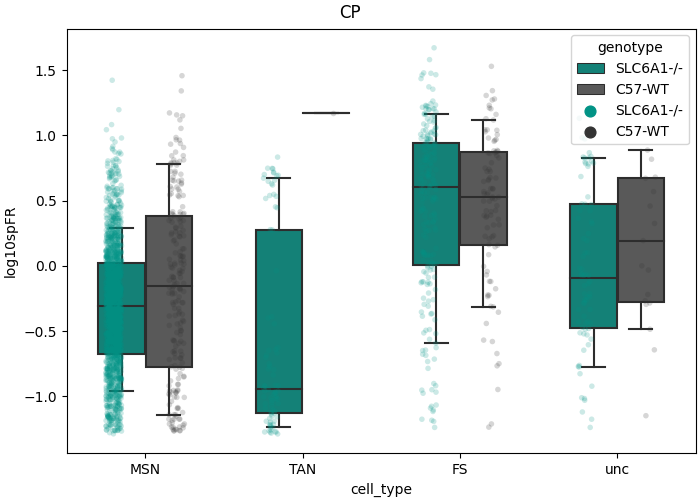

In [80]:
fig = plt.figure(figsize=(7,5), constrained_layout=True)
sns.boxplot(
    data=regidf, x="cell_type", y="log10spFR", hue="genotype",
    whis=[10, 90], showfliers=False, width=.6, palette={"SLC6A1-/-": "xkcd:teal", "C57-WT": ".35"}
)
sns.stripplot(
    data=regidf, x="cell_type", y="log10spFR", hue="genotype", size=4, palette={"SLC6A1-/-": "xkcd:teal", "C57-WT": ".2"}, dodge=True, alpha=0.2
)
fig.suptitle(region)
## Save ##
figname = 'multisub_SLC-WT_spontFR_{}allct_{}.png'.format(region, date.today().strftime('%b%d%Y'))
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

### For thalamus

In [99]:
pregions = ['TH']
pselect = []
for pregi in pregions:
    pselect.append(all_select_units[all_select_units['parent_region'] == pregi])
parentdf = pd.concat(pselect, ignore_index=True)
print(np.unique(parentdf['cell_type'].values))
print(np.unique(parentdf['region'].values))
print(len(parentdf))

['TC' 'pRT']
['AD' 'AMd' 'AMv' 'AV' 'CL' 'Eth' 'FF' 'HY' 'IAD' 'LD' 'LGd-co' 'LGd-sh'
 'LGv' 'LP' 'MD' 'MGd' 'MGm' 'MGv' 'PCN' 'PIL' 'PO' 'POL' 'PoT' 'RT' 'SGN'
 'TH' 'VAL' 'VL' 'VPL' 'VPM' 'ZI' 'alv' 'em' 'fi' 'fiber tracts' 'int'
 'ml' 'or' 'root' 'st']
6822


In [ ]:
HY_regions = ['FF', 'HY', 'ZI']

In [101]:
region = 'RT'
regidf = all_select_units[all_select_units['region'] == region]
print(np.unique(regidf['parent_region'].values))
print(np.unique(regidf['cell_type'].values))
print(len(regidf))

['TH']
['TC' 'pRT']
586


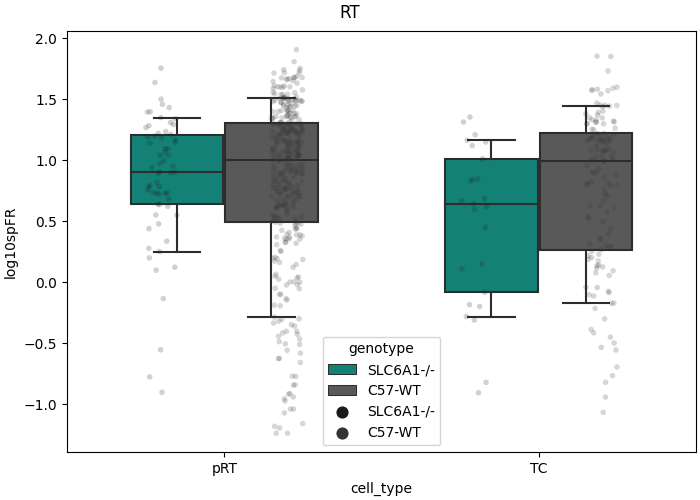

In [105]:
fig = plt.figure(figsize=(7,5), constrained_layout=True)
sns.boxplot(
    data=regidf, x="cell_type", y="log10spFR", hue="genotype",
    whis=[10, 90], showfliers=False, width=.6, palette={"SLC6A1-/-": "xkcd:teal", "C57-WT": ".35"}
)
sns.stripplot(
    data=regidf, x="cell_type", y="log10spFR", hue="genotype", size=4, palette={"SLC6A1-/-": ".1", "C57-WT": ".2"}, dodge=True, alpha=0.2
)
fig.suptitle(region)
## Save ##
figname = 'multisub_SLC-WT_spontFR_{}allct_{}.png'.format(region, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

### For hippocampus

In [95]:
pregions = ['HIP']
pselect = []
for pregi in pregions:
    pselect.append(all_select_units[all_select_units['parent_region'] == pregi])
parentdf = pd.concat(pselect, ignore_index=True)
print(np.unique(parentdf['parent_region'].values))
print(np.unique(parentdf['region'].values))
print(len(parentdf))

['HIP']
['CA1' 'CA2' 'CA3' 'DG-mo' 'DG-po' 'DG-sg' 'alv' 'bsc' 'ccb' 'ccg' 'ccs'
 'fi' 'fiber tracts' 'fp' 'root']
2901


In [98]:
region = 'CA3'
regidf = all_select_units[all_select_units['region'] == region]
print(np.unique(regidf['parent_region'].values))
print(len(regidf))

['HIP']
922


Text(0.5, 1.0, 'Spontaneous firing rates: STR')

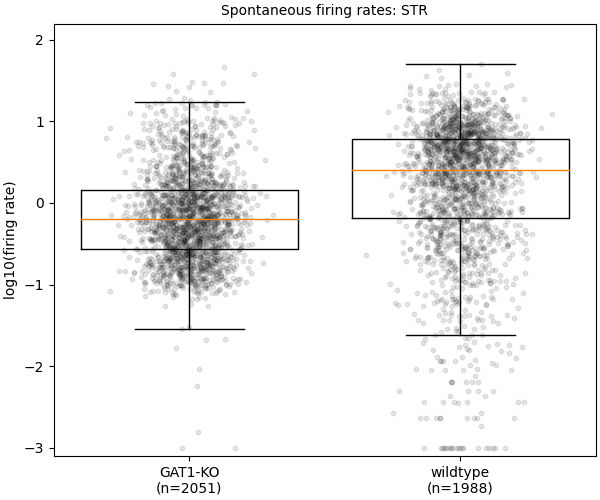

In [16]:
regi = 'STR'
fig, ax = plt.subplots(figsize=(6,5), constrained_layout=True)
xlabels = []
for ii, group in enumerate(['GAT1-KO', 'wildtype']):
    tempdf = all_select_units[(all_select_units['genotype'] == group) & (all_select_units['parent_region'] == regi)]
    yvals = np.log10(tempdf['spont_FR'].values + 1E-3)
    xs = np.random.normal(ii, 0.1, len(yvals))
    ax.boxplot(yvals, positions=[ii], widths=[0.8], showfliers=False)
    ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
    xlabels.append('{}\n(n={:d})'.format(group, len(yvals)))
ax.set_xticks(np.arange(len(xlabels)))
ax.set_xticklabels(xlabels)
ax.set_ylabel('log10(firing rate)')
ax.set_ylim([-3.1, 2.2])

ax.set_title('Spontaneous firing rates: {}'.format(regi))

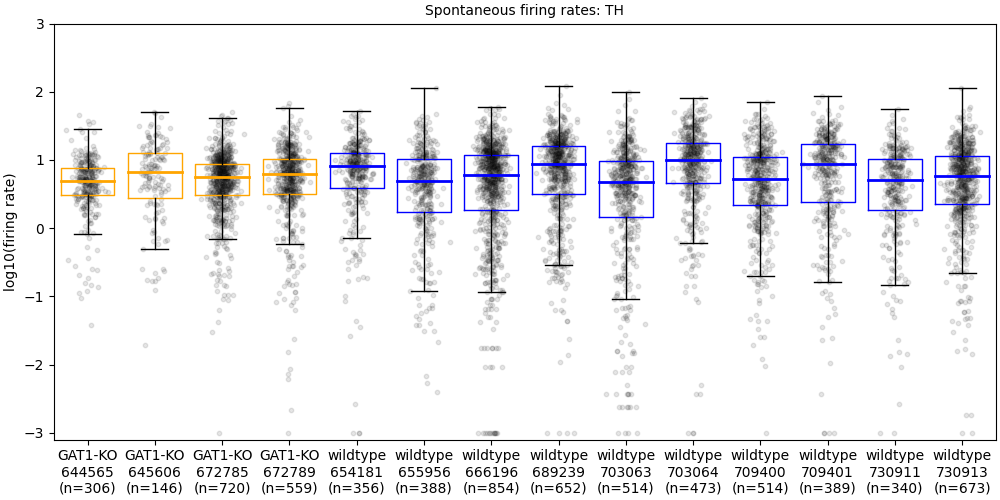

In [19]:
regi = 'TH'
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
xlabels = []
regidf = all_select_units[all_select_units['parent_region'] == regi]
xi = 0
for ii, group in enumerate(['GAT1-KO', 'wildtype']):
    groupdf = regidf[regidf['genotype'] == group]
    if group == 'GAT1-KO':
        gcol = 'orange'
    else:
        gcol = 'blue'
    subjects = np.unique(groupdf['mouse'].values)
    for jj, subi in enumerate(subjects):
        subdf = groupdf[groupdf['mouse'] == subi]
        yvals = np.log10(subdf['spont_FR'].values + 1E-3)
        xs = np.random.normal(xi, 0.1, len(yvals))
        ax.boxplot(yvals, positions=[xi], widths=[0.8], showfliers=False, medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol})
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
        xlabels.append('{}\n{}\n(n={:d})'.format(group, subi, len(yvals)))
        xi += 1
ax.set_xticks(np.arange(xi))
ax.set_xticklabels(xlabels)
ax.set_ylabel('log10(firing rate)')
ax.set_ylim([-3.1, 3.0])
ax.set_title('Spontaneous firing rates: {}'.format(regi))

## Save ##
figname = 'multisub_GAT-control_spontFR_{}_{}.png'.format(regi, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

Plot individual regions

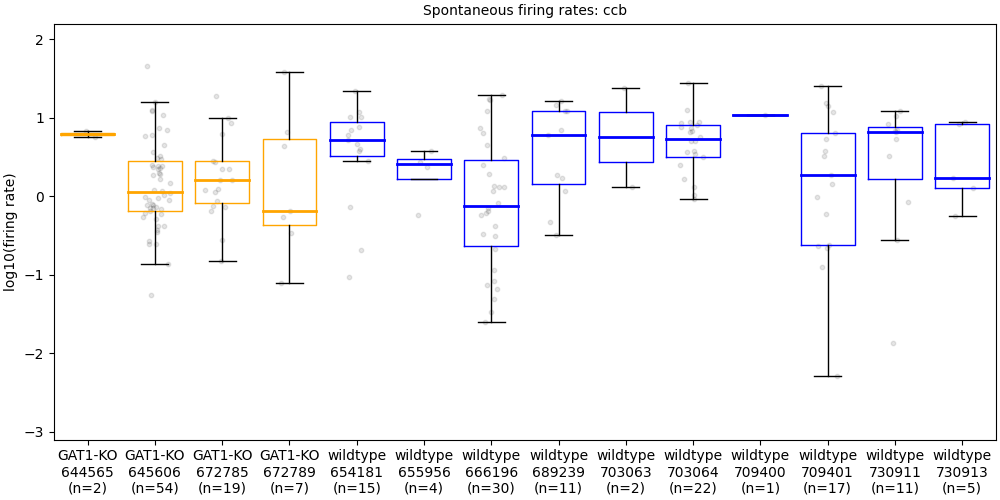

In [69]:
indregi = 'ccb'
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
xlabels = []
regidf = all_select_units[all_select_units['region'] == indregi]
xi = 0
for ii, group in enumerate(['GAT1-KO', 'wildtype']):
    groupdf = regidf[regidf['genotype'] == group]
    if group == 'GAT1-KO':
        gcol = 'orange'
    else:
        gcol = 'blue'
    subjects = np.unique(groupdf['mouse'].values)
    for jj, subi in enumerate(subjects):
        subdf = groupdf[groupdf['mouse'] == subi]
        yvals = np.log10(subdf['spont_FR'].values + 1E-3)
        xs = np.random.normal(xi, 0.1, len(yvals))
        ax.boxplot(yvals, positions=[xi], widths=[0.8], showfliers=False, medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol})
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
        xlabels.append('{}\n{}\n(n={:d})'.format(group, subi, len(yvals)))
        xi += 1
ax.set_xticks(np.arange(xi))
ax.set_xticklabels(xlabels)
ax.set_ylabel('log10(firing rate)')
ax.set_ylim([-3.1, 2.2])
ax.set_title('Spontaneous firing rates: {}'.format(indregi))

## Save ##
figname = 'multisub_GAT-control_spontFR_{}_{}.png'.format(indregi, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

#### Bursting

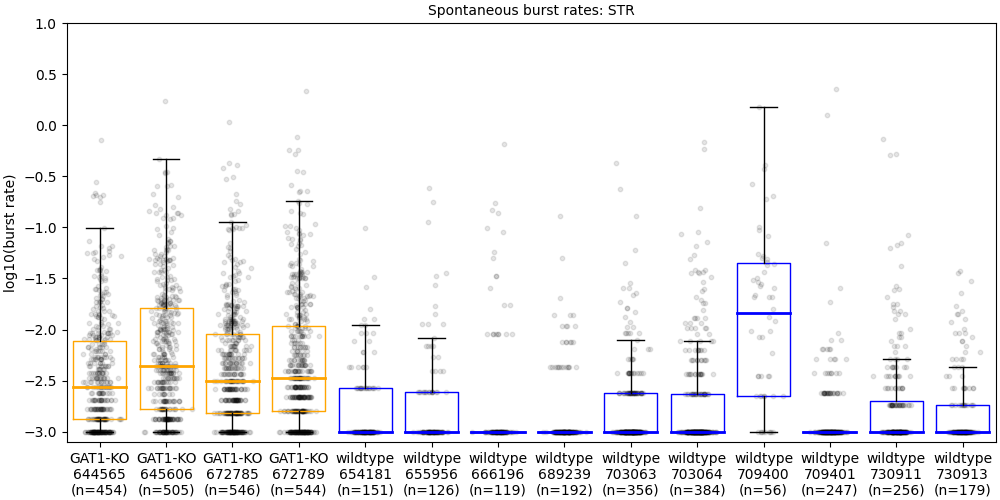

In [17]:
regi = 'STR'
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
xlabels = []
regidf = all_select_units[all_select_units['parent_region'] == regi]
xi = 0
for ii, group in enumerate(['GAT1-KO', 'wildtype']):
    groupdf = regidf[regidf['genotype'] == group]
    if group == 'GAT1-KO':
        gcol = 'orange'
    else:
        gcol = 'blue'
    subjects = np.unique(groupdf['mouse'].values)
    for jj, subi in enumerate(subjects):
        subdf = groupdf[groupdf['mouse'] == subi]
        yvals = np.log10(subdf['spont_BR'].values + 1E-3)
        xs = np.random.normal(xi, 0.1, len(yvals))
        ax.boxplot(yvals, positions=[xi], widths=[0.8], showfliers=False, medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol})
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
        xlabels.append('{}\n{}\n(n={:d})'.format(group, subi, len(yvals)))
        xi += 1
ax.set_xticks(np.arange(xi))
ax.set_xticklabels(xlabels)
ax.set_ylabel('log10(burst rate)')
ax.set_ylim([-3.1, 1.0])
ax.set_title('Spontaneous burst rates: {}'.format(regi))

## Save ##
figname = 'multisub_GAT-control_spontburst_{}_{}.png'.format(regi, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

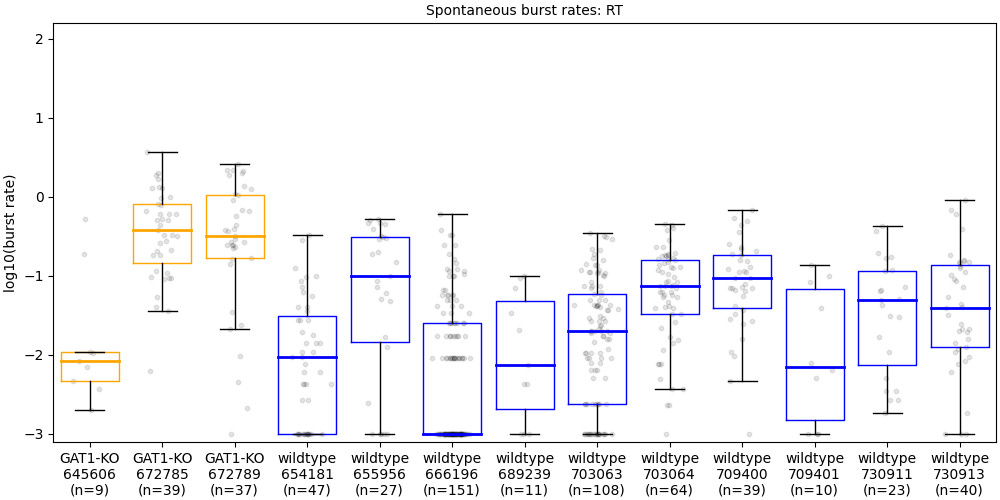

In [16]:
indregi = 'RT'
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
xlabels = []
regidf = all_select_units[all_select_units['region'] == indregi]
xi = 0
for ii, group in enumerate(['GAT1-KO', 'wildtype']):
    groupdf = regidf[regidf['genotype'] == group]
    if group == 'GAT1-KO':
        gcol = 'orange'
    else:
        gcol = 'blue'
    subjects = np.unique(groupdf['mouse'].values)
    for jj, subi in enumerate(subjects):
        subdf = groupdf[groupdf['mouse'] == subi]
        yvals = np.log10(subdf['spont_BR'].values + 1E-3)
        xs = np.random.normal(xi, 0.1, len(yvals))
        ax.boxplot(yvals, positions=[xi], widths=[0.8], showfliers=False, medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol})
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
        xlabels.append('{}\n{}\n(n={:d})'.format(group, subi, len(yvals)))
        xi += 1
ax.set_xticks(np.arange(xi))
ax.set_xticklabels(xlabels)
ax.set_ylabel('log10(burst rate)')
ax.set_ylim([-3.1, 2.2])
ax.set_title('Spontaneous burst rates: {}'.format(indregi))

## Save ##
figname = 'multisub_GAT-control_spontburst_{}_{}.png'.format(indregi, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

#### Burst proportion

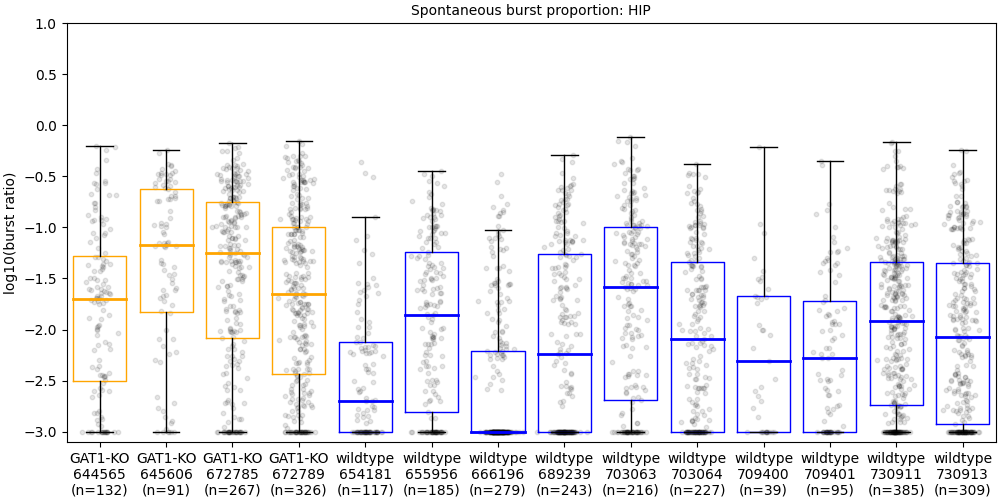

In [28]:
regi = 'HIP'
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
xlabels = []
regidf = all_select_units[all_select_units['parent_region'] == regi]
xi = 0
for ii, group in enumerate(['GAT1-KO', 'wildtype']):
    groupdf = regidf[regidf['genotype'] == group]
    if group == 'GAT1-KO':
        gcol = 'orange'
    else:
        gcol = 'blue'
    subjects = np.unique(groupdf['mouse'].values)
    for jj, subi in enumerate(subjects):
        subdf = groupdf[groupdf['mouse'] == subi]
        yvals = np.log10(subdf['burst_ratio'].values[~np.isnan(subdf['burst_ratio'].values)] + 1E-3)
        xs = np.random.normal(xi, 0.1, len(yvals))
        ax.boxplot(yvals, positions=[xi], widths=[0.8], showfliers=False, medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol})
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
        xlabels.append('{}\n{}\n(n={:d})'.format(group, subi, len(yvals)))
        xi += 1
ax.set_xticks(np.arange(xi))
ax.set_xticklabels(xlabels)
ax.set_ylabel('log10(burst ratio)')
ax.set_ylim([-3.1, 1.0])
ax.set_title('Spontaneous burst proportion: {}'.format(regi))

## Save ##
figname = 'multisub_GAT-control_burstratio_{}_{}.png'.format(regi, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

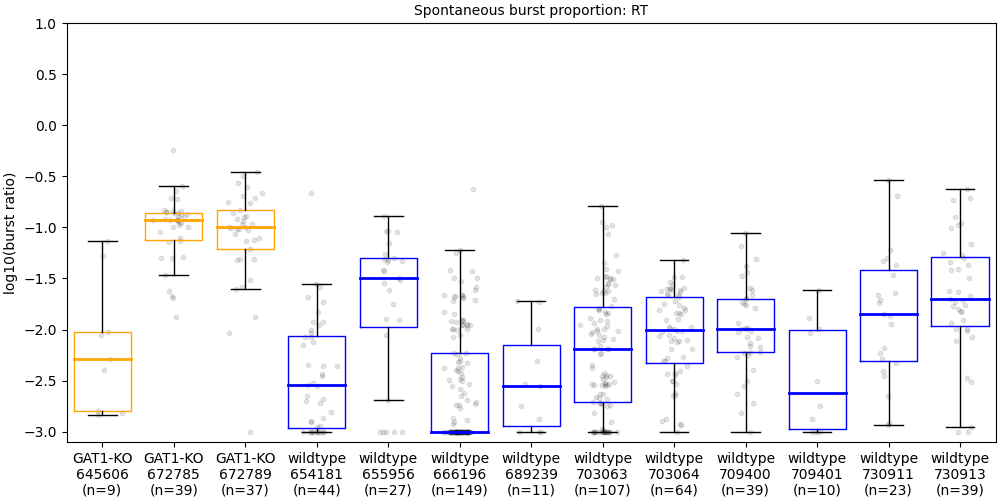

In [30]:
indregi = 'RT'
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
xlabels = []
regidf = all_select_units[all_select_units['region'] == indregi]
xi = 0
for ii, group in enumerate(['GAT1-KO', 'wildtype']):
    groupdf = regidf[regidf['genotype'] == group]
    if group == 'GAT1-KO':
        gcol = 'orange'
    else:
        gcol = 'blue'
    subjects = np.unique(groupdf['mouse'].values)
    for jj, subi in enumerate(subjects):
        subdf = groupdf[groupdf['mouse'] == subi]
        yvals = np.log10(subdf['burst_ratio'].values[~np.isnan(subdf['burst_ratio'].values)] + 1E-3)
        xs = np.random.normal(xi, 0.1, len(yvals))
        ax.boxplot(yvals, positions=[xi], widths=[0.8], showfliers=False, medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol})
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
        xlabels.append('{}\n{}\n(n={:d})'.format(group, subi, len(yvals)))
        xi += 1
ax.set_xticks(np.arange(xi))
ax.set_xticklabels(xlabels)
ax.set_ylabel('log10(burst ratio)')
ax.set_ylim([-3.1, 1.0])
ax.set_title('Spontaneous burst proportion: {}'.format(indregi))

## Save ##
figname = 'multisub_GAT-control_burstratio_{}_{}.png'.format(indregi, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

In [ ]:
choose_event = 4
eventrow = simple_log.iloc[choose_event]
print(eventrow)
event_stims = stim_log[stim_log['event_ID'] == choose_event]
event_stims.head()

In [ ]:
plot_regions = ['TH', 'HIP', 'STR', 'VIS', 'SS', 'MO']
umax = 100
pdelta = 10. # plot before and after, s
pwindow = [eventrow.onset - pdelta, eventrow.offset + pdelta]

fig = plt.figure(figsize=(10, 7)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.06, right=0.98, top=0.95, bottom=0.08, hspace=0.05, height_ratios=[1,5])
aax = fig.add_subplot(gs[0])
rasterax = fig.add_subplot(gs[1], sharex=aax)

## Plot pupil ##
pupilinds = np.nonzero((pupilts > pwindow[0]) & (pupilts < pwindow[1]))[0]
aax.axvspan(eventrow.onset, eventrow.offset, color='g', alpha=0.05)
# aax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.05)
# aax.axhline(awake_pupil_mean, color='b', linestyle='dashed', alpha=0.2)
for si, stimi in event_stims.iterrows():
    aax.axvline(stimi.onset, color='g', linewidth=0.5, alpha=0.2)
aax.plot(pupilts[pupilinds], sm_pupil[pupilinds])
aax.set_xlim(pwindow)
# aax.set_xlabel('Time (s)')
aax.set_ylabel('Pupil size (pixels)')

## Plot raster ##
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(plot_regions):
    regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    if len(regdf) > umax:
        punitinds = np.random.choice(range(len(regdf)), size=umax, replace=False)
    else:
        punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > pwindow[0]) & (uspiketimes < pwindow[1]))[0]
        ]
        rasterax.eventplot(SWDspikes, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}'.format(pregi), xy=(pwindow[0], last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)

rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(pwindow)
rasterax.set_xlabel('Time (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])

### SAVE ###
# fig_name = 'spont_EEG_NPX_{:d}-{:d}s.png'.format(int(window[0]), int(window[1]))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

### Load EEG data

In [ ]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [ ]:
print(eeg_ts[0])
print(eeg_ts[-1])

In [ ]:
bpb, bpa = signal.butter(3, np.array([0.5, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)